In [58]:
import os
import glob
from matplotlib import pyplot as plt
import numpy as np
from PIL import Image

import torch 
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import Dataset, DataLoader
from torchvision.utils import make_grid
from torchvision.datasets import ImageFolder

import torchvision.transforms as transforms
import torchvision.models as models





In [59]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device 

device(type='cuda')

In [60]:
def display_images(image_paths, title, max_images=4):
    plt.figure(figsize=(12, 4))
    for i, image_path in enumerate(image_paths[:max_images]):
        img = plt.imread(image_path)
        plt.subplot(1, max_images, i+1)
        plt.imshow(img)
        plt.title(title)
        plt.axis("off")
    plt.tight_layout()
    plt.show()
        


Train chihuahua 이미지 개수: 2579


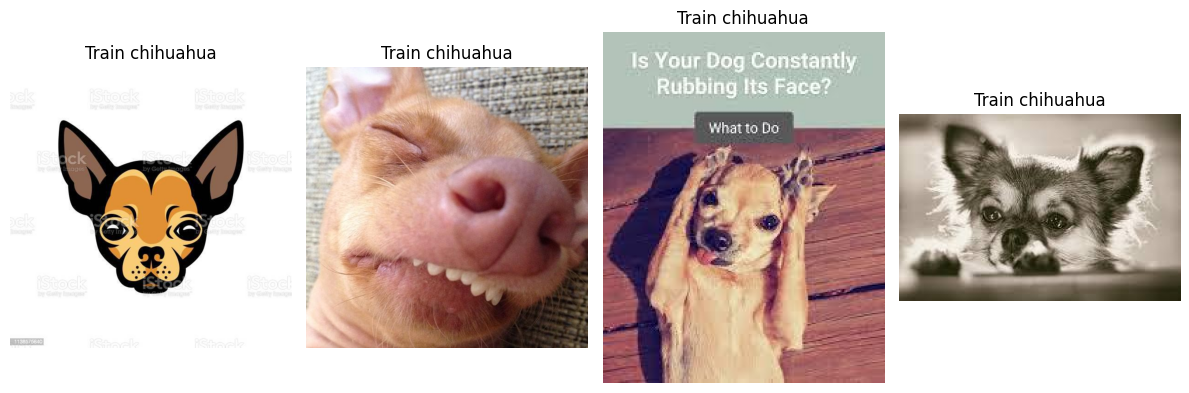

Train muffin 이미지 개수: 2224


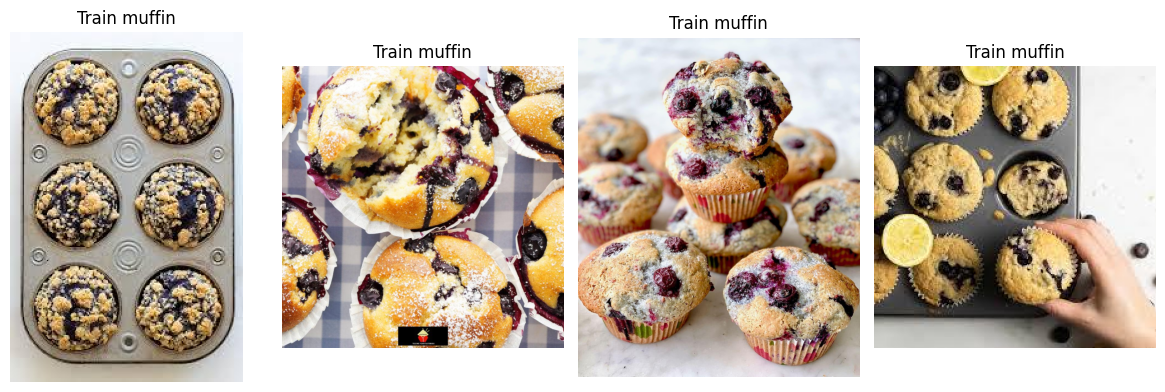

Val chihuahua 이미지 개수: 622


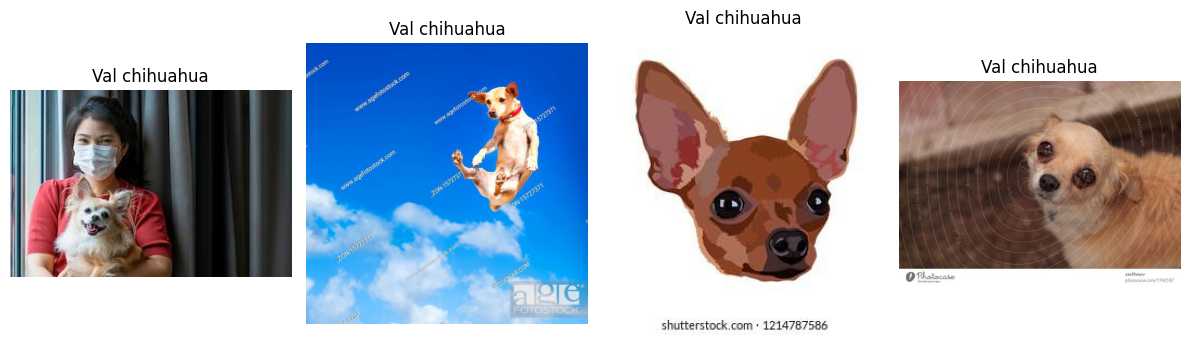

Val muffin 이미지 개수: 554


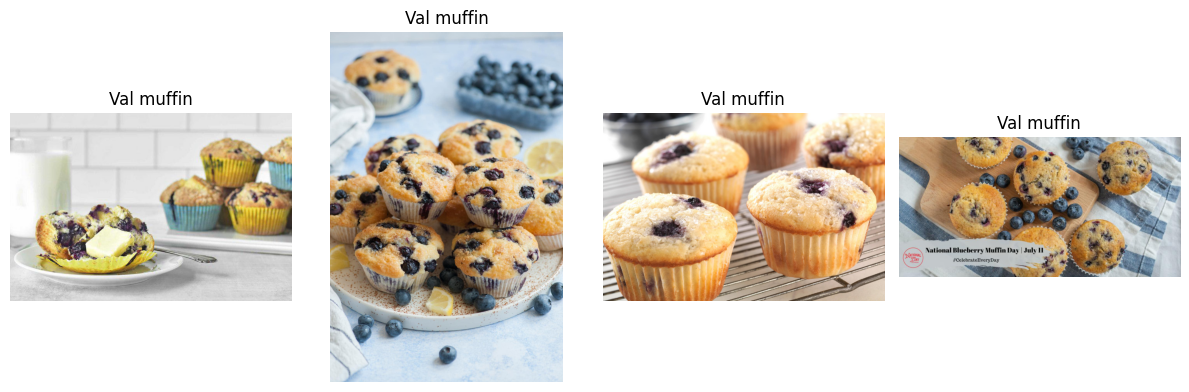

Test chihuahua 이미지 개수: 18


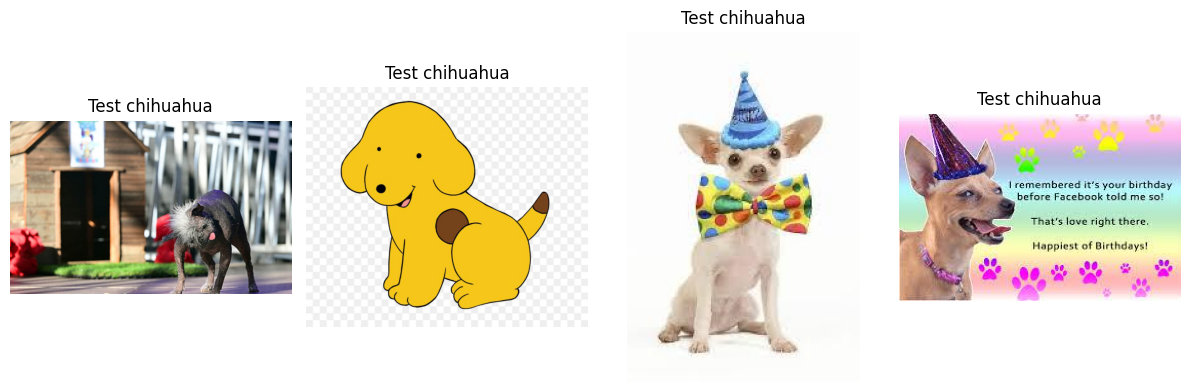

Test muffin 이미지 개수: 18


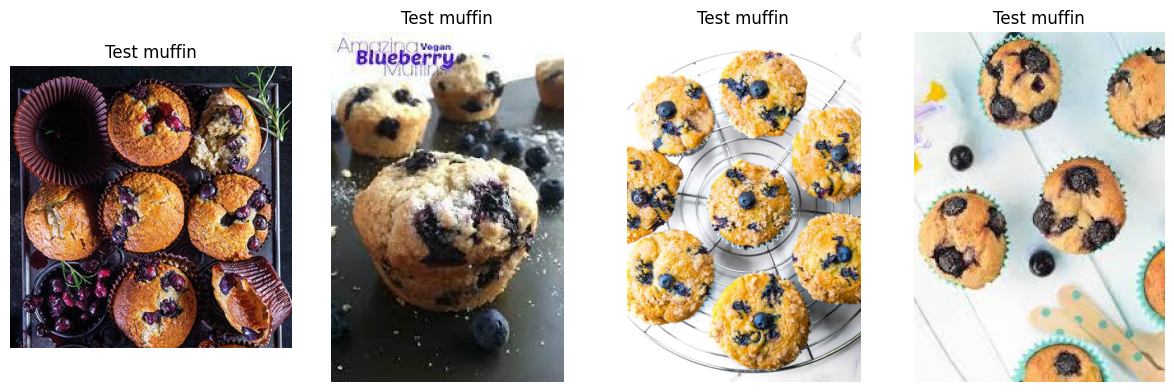

In [61]:
categories = ['Train chihuahua', 'Train muffin', 'Val chihuahua', 'Val muffin', 'Test chihuahua', 'Test muffin']

for category in categories:
    image_paths = glob.glob(f"../실습 파일/6/{category.lower().replace(' ', '/')}/*")
    print(f"{category} 이미지 개수: {len(image_paths)}")
    display_images(image_paths, category)


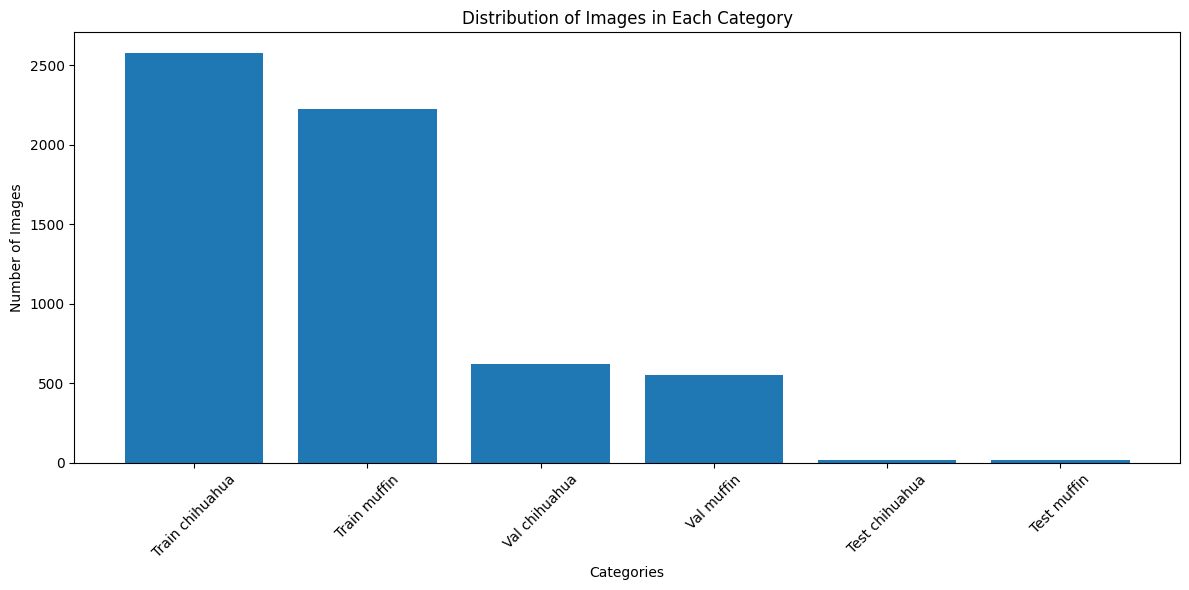

In [62]:
plt.figure(figsize=(12, 6))
plt.bar(categories, [len(glob.glob(f"../실습 파일/6/{category.lower().replace(' ', '/')}/*")) for category in categories])
plt.xlabel("Categories")
plt.ylabel("Number of Images")
plt.title("Distribution of Images in Each Category")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



In [63]:
from imgaug import augmenters as iaa
import imgaug as ia

# imgaug를 사용한 커스텀 데이터셋 정의

class ImgAugTransform:
    def __init__(self):
        self.aug = iaa.Sequential([
            iaa.LinearContrast((0.5, 1.5)),
            iaa.Crop(percent=(0, 0.2)),
            iaa.GaussianBlur(sigma=(0, 3.0)),
            iaa.AdditiveGaussianNoise(scale=(10, 0.2*255)),
            iaa.Fliplr(0.5),
            iaa.Flipud(0.2),
            iaa.Affine(
                scale=(0.5, 1.5),
                translate_percent=(-0.2, 0.2),
                rotate=(-20, 20),
                mode="symmetric")
            ])
        
    def __call__(self, img):
        img = np.array(img)
        img = self.aug.augment_image(img)
        return img
    

#  커스텀 데이터셋 클래스 
class CustomDataset(ImageFolder):
    def __init__(self, root, imgaug = None, transform=None):
        super(CustomDataset, self).__init__(root=root, transform=transform)
        self.imgaug_transform = imgaug # imgaug 매개변수를 직접 저장
    
    def __getitem__(self, index):
        path, target = self.samples[index]
        img = self.loader(path)
        
        # imgaug 적용
        if self.imgaug_transform is not None:
            img = self.imgaug_transform(img)
            
            # imgaug는 numpy 배열을 반환하므로, PIL 이미지로 변환
            img = Image.fromarray(img)
            
        if self.transform is not None:
            img = self.transform(img)
            
        return img, target
    
            
        
    
                


In [64]:
# Pytorch transform에서 ToTensor 및 Normalize 적용

pytorch_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])





In [65]:
train_path = "../실습 파일/6/Train"
val_path = "../실습 파일/6/Val"
test_path = "../실습 파일/6/Test"

In [66]:
train_dataset = CustomDataset(train_path, imgaug=ImgAugTransform(), transform=pytorch_transform)
val_dataset = CustomDataset(val_path, transform=pytorch_transform)
test_dataset = CustomDataset(test_path, transform=pytorch_transform)



In [67]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, pin_memory=True)

In [68]:
def imshow(img, size=(20, 20), mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    img = img.numpy().transpose((1, 2, 0))
    mean = np.array(mean)
    std = np.array(std)
    img = std * img + mean
    img = np.clip(img, 0, 1)
    plt.figure(figsize=size)
    plt.imshow(img)
    plt.axis("off")
    plt.show()
    
    


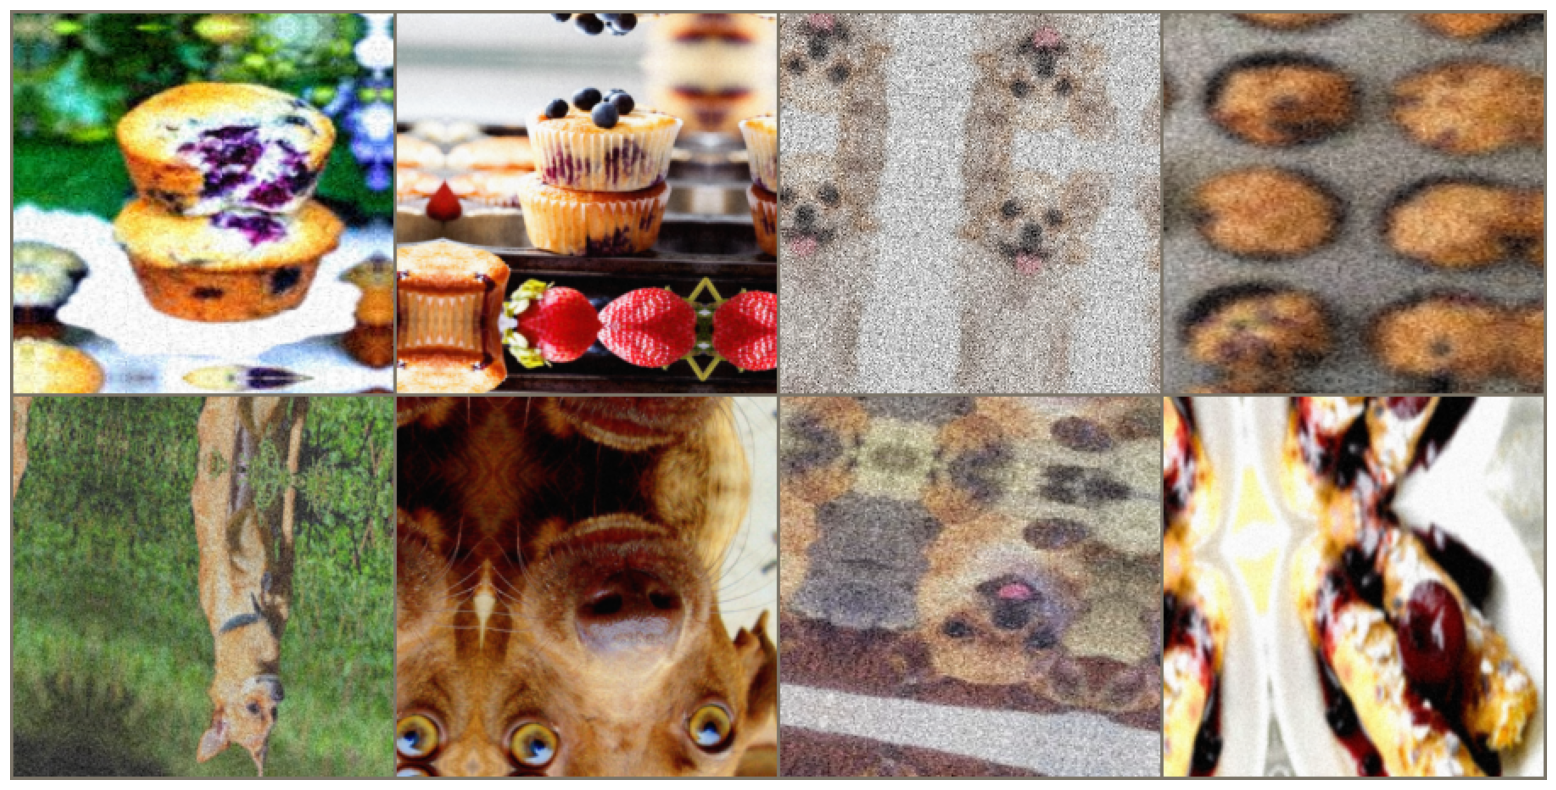

In [69]:
dataiter = iter(train_loader)
images, _ = next(dataiter)

# 이미지 그리드 생성 및 시각화, nrow를 조정하여 한줄에 표시되는 이미지의 수 조정
imshow(make_grid(images[:8], nrow=4), size=(20, 10))








In [70]:
class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.conv3 = nn.Conv2d(out_channels, out_channels * self.expansion, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(out_channels * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out

In [71]:
class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=1000):
        super(ResNet, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        if stride != 1 or self.in_channels != out_channels * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels * block.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * block.expansion),
            )

        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.in_channels, out_channels))

        return nn.Sequential(*layers)

# Ex)
# 64 64 256, 256 256 256, 256 256 256 -> 128 128 512, 512 512 512, 512 512 512, 512 512 512 ->
# 256 256 1024, 1024 1024 1024, 1024 1024 1024, 1024 1024 1024, 1024 1024 1024, 1024 1024 1024 -> 512 512 2048, 2048 2048 2048, 2048 2048 2048

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

def resnet50(num_classes=1000):
    return ResNet(Bottleneck, [3, 4, 6, 3], num_classes)

In [72]:
# 사전 학습된 resnet50 모델 불러오기
pretrained_resnet50 = models.resnet50(pretrained=True)
# 새로 정의한 모델 인스턴스 생성
net = resnet50(num_classes=1000)


# 사전 학습된 모델의 features 부분에서 가중치 추출
pretrained_keys = set(pretrained_resnet50.state_dict().keys())
# 사전 학습된 모델에서 커스텀 모델로 가중치 복사 시도
result = net.load_state_dict(pretrained_resnet50.state_dict(), strict=False)
# 복사 후 커스텀 모델의 features 부분에서 가중치 추출
custom_keys = set(net.state_dict().keys())


# 성공적으로 복사된 가중치 (커스텀 모델과 사전 학습된 모델 모두에 존재)
successfully_copied_keys = pretrained_keys.intersection(custom_keys)
# 커스텀 모델에 있지만 사전 학습된 모델에 없는 가중치
missing_keys = custom_keys - pretrained_keys
# 사전 학습된 모델에 있지만 커스텀 모델에 없는 가중치
unexpected_keys = pretrained_keys - custom_keys

print("성공적으로 복사된 가중치:", successfully_copied_keys)
print("커스텀 모델에는 있지만 사전 학습된 모델에는 없는 가중치 (누락):", result.missing_keys)
print("사전 학습된 모델에는 있지만 커스텀 모델에는 없는 가중치 (예상치 못한):", result.unexpected_keys) # net 모델에 없는데 pretrained_vgg19 가중치 파일에는 존재하는 항목의 이름이 리스트로 반환

성공적으로 복사된 가중치: {'layer3.5.bn2.running_var', 'layer3.0.bn1.weight', 'layer2.0.downsample.1.bias', 'layer2.2.bn2.running_mean', 'layer1.2.bn1.weight', 'layer1.0.downsample.1.running_var', 'layer2.3.bn2.num_batches_tracked', 'layer2.3.bn3.bias', 'layer1.1.bn3.running_var', 'layer3.4.bn2.num_batches_tracked', 'layer3.1.bn2.running_var', 'layer4.0.downsample.1.weight', 'layer3.5.bn1.running_mean', 'layer4.2.bn3.running_var', 'layer3.2.bn2.weight', 'layer2.1.bn1.running_mean', 'layer4.2.bn1.num_batches_tracked', 'layer3.5.conv1.weight', 'layer4.1.bn3.weight', 'layer3.2.bn1.running_var', 'layer3.2.bn1.num_batches_tracked', 'layer3.0.downsample.0.weight', 'layer4.0.bn2.running_var', 'layer3.4.bn1.num_batches_tracked', 'layer3.4.bn3.weight', 'layer1.0.conv1.weight', 'layer1.0.bn1.running_var', 'layer1.0.bn2.running_var', 'layer1.1.bn3.bias', 'layer3.3.bn2.running_mean', 'layer2.1.bn1.weight', 'layer2.0.conv1.weight', 'layer3.3.bn1.num_batches_tracked', 'layer2.0.bn3.bias', 'layer4.1.bn1.bias', 

In [73]:
print(net)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [74]:
for param in net.parameters():
    param.requires_grad = False



In [75]:
# classifier 부분의 가중치는 재학습을 위해 새로 정의

net.fc = nn.Linear(2048, 2)

for param in net.fc.parameters():
    param.requires_grad = True

net = net.to(device)


In [76]:
criterion = nn.CrossEntropyLoss()


In [77]:
from re import T


def train_model(optimizer_name, net, train_loader, val_loader, criterion, num_epochs=20):
    if optimizer_name == 'SGD':
        optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
    elif optimizer_name == 'Adam':
        optimizer = optim.Adam(net.parameters(), lr=0.0001)
    elif optimizer_name == 'RAdam':
        optimizer = optim.RAdam(net.parameters(), lr=0.0001)
    elif optimizer_name == 'AdamW':
        optimizer = optim.AdamW(net.parameters(), lr=0.0001)
    else:
        raise ValueError(f"Invalid optimizer: {optimizer_name}")
    
    train_losses = []
    val_losses = []
    val_accuracies = []
    
    for epoch in range(num_epochs):
        net.train()
        running_loss = 0.0
        
        for i, data in enumerate(train_loader):
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            
            optimizer.step()
            running_loss += loss.item()
            
        train_loss = running_loss / len(train_loader)
        train_losses.append(train_loss)
        
        val_loss = 0.0
        net.eval()
        correct = 0
        total = 0
        
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                outputs = net(inputs)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                
        val_loss = val_loss / len(val_loader)
        val_losses.append(val_loss)
        val_accuracy = 100 * correct / total
        val_accuracies.append(val_accuracy)
        
        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")
        
    return train_losses, val_losses, val_accuracies


In [78]:
train_losses_Adam = train_model('Adam', net, train_loader, val_loader, criterion)

Epoch 1/20, Train Loss: 0.4590, Val Loss: 0.2007, Val Accuracy: 97.79%
Epoch 2/20, Train Loss: 0.2374, Val Loss: 0.1101, Val Accuracy: 97.96%
Epoch 3/20, Train Loss: 0.1917, Val Loss: 0.0825, Val Accuracy: 98.47%
Epoch 4/20, Train Loss: 0.1620, Val Loss: 0.0682, Val Accuracy: 98.55%
Epoch 5/20, Train Loss: 0.1490, Val Loss: 0.0632, Val Accuracy: 98.30%
Epoch 6/20, Train Loss: 0.1416, Val Loss: 0.0546, Val Accuracy: 98.55%
Epoch 7/20, Train Loss: 0.1320, Val Loss: 0.0513, Val Accuracy: 98.47%
Epoch 8/20, Train Loss: 0.1254, Val Loss: 0.0511, Val Accuracy: 98.04%
Epoch 9/20, Train Loss: 0.1235, Val Loss: 0.0441, Val Accuracy: 98.38%
Epoch 10/20, Train Loss: 0.1228, Val Loss: 0.0415, Val Accuracy: 98.64%
Epoch 11/20, Train Loss: 0.1186, Val Loss: 0.0400, Val Accuracy: 98.64%
Epoch 12/20, Train Loss: 0.1185, Val Loss: 0.0409, Val Accuracy: 98.72%
Epoch 13/20, Train Loss: 0.1142, Val Loss: 0.0404, Val Accuracy: 98.30%
Epoch 14/20, Train Loss: 0.1091, Val Loss: 0.0307, Val Accuracy: 99.23%
E

In [88]:
train_losses_Adam

([0.45895002219850656,
  0.23735707919329208,
  0.1917435938356728,
  0.16199388577053878,
  0.14901730080215347,
  0.14160713795202456,
  0.1319556337170648,
  0.1254147005248938,
  0.12352418814421884,
  0.1227737958758872,
  0.11864951165355989,
  0.11849406941343617,
  0.11424344332753034,
  0.10912823282330242,
  0.11626898438133151,
  0.10537468328677266,
  0.11437775953271925,
  0.11126992942160921,
  0.11152408100565933,
  0.10360237181384042],
 [0.2007010854982041,
  0.11014118649669595,
  0.08249324117157911,
  0.06823509554001125,
  0.063233826208759,
  0.05458103611159164,
  0.05125569844165364,
  0.05109670680217646,
  0.04405537118027742,
  0.04147545769307259,
  0.04004366882145405,
  0.040893431249502545,
  0.04043686338322791,
  0.03067346162640968,
  0.05192960677290889,
  0.03338297262687136,
  0.037315512938122894,
  0.030790611686235345,
  0.02920588054945944,
  0.0340754679857275],
 [97.78911564625851,
  97.95918367346938,
  98.46938775510205,
  98.55442176870748,

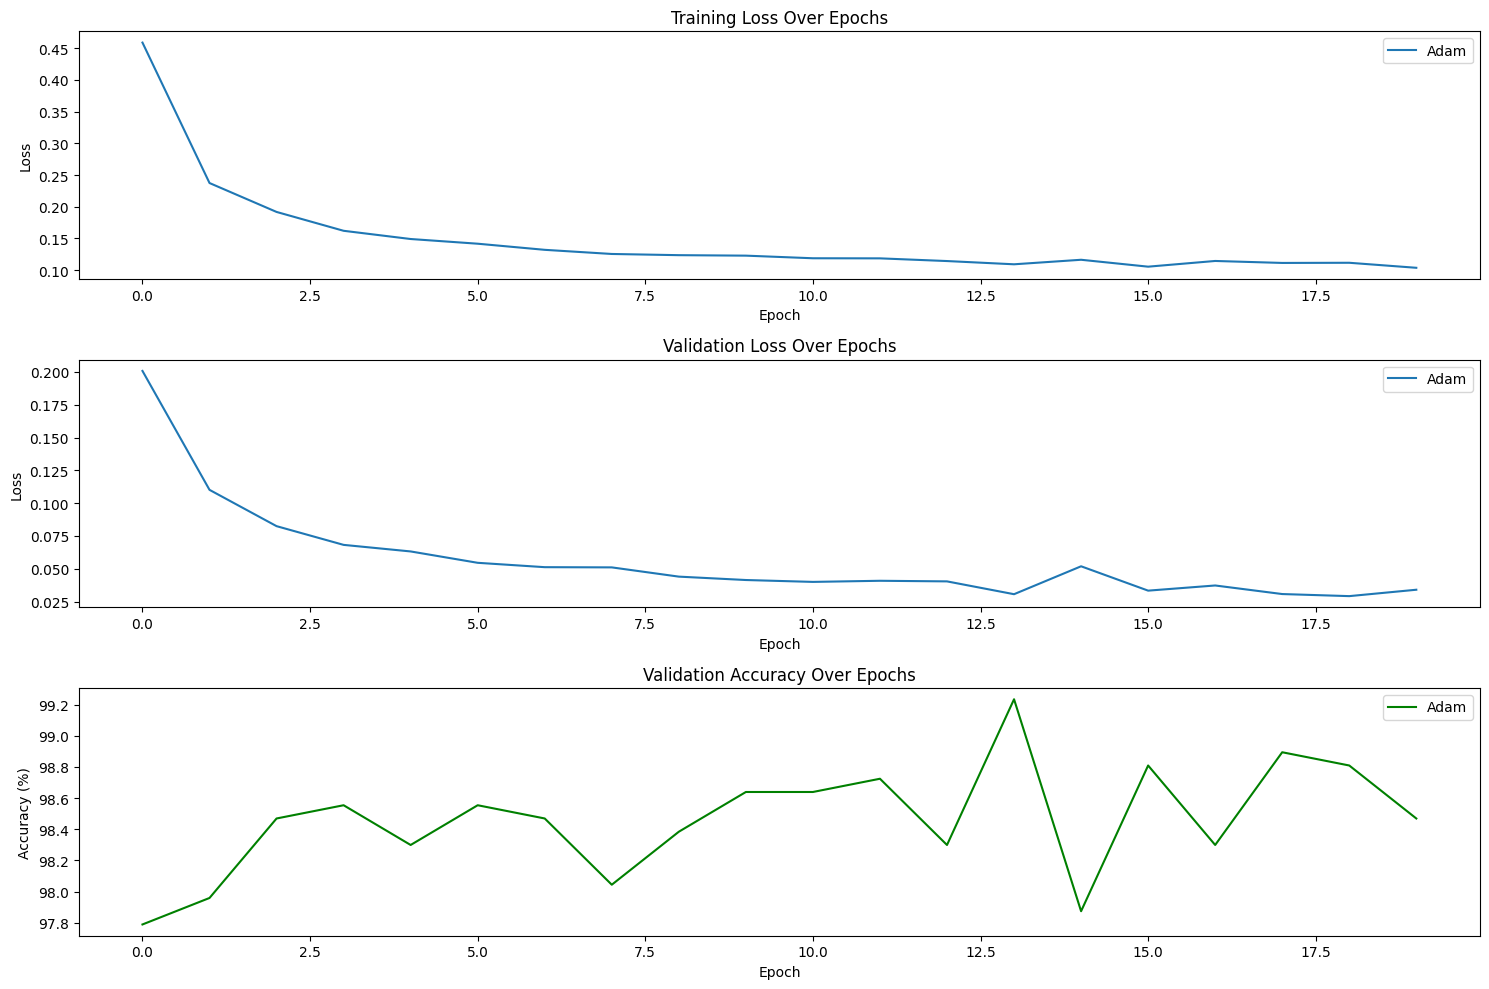

In [87]:
# 학습 손실과 검증 정확도 그래프 그리기
plt.figure(figsize=(15, 10))

# 학습 손실 그래프
plt.subplot(3, 1, 1)  # 3행 1열의 첫 번째 위치
plt.plot(train_losses_Adam[0], label='Adam')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()

# 검증 손실 그래프
plt.subplot(3, 1, 2)  # 3행 1열의 두 번째 위치
plt.plot(train_losses_Adam[1], label='Adam')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Validation Loss Over Epochs')
plt.legend()

# 검증 정확도 그래프
plt.subplot(3, 1, 3)  # 3행 1열의 세 번째 위치
plt.plot(train_losses_Adam[2], label='Adam', color='green')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Validation Accuracy Over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

In [80]:
def load_and_transform_image(image_path, transform):
    image = Image.open(image_path).convert('RGB')
    image = transform(image).unsqueeze(0)
    return image






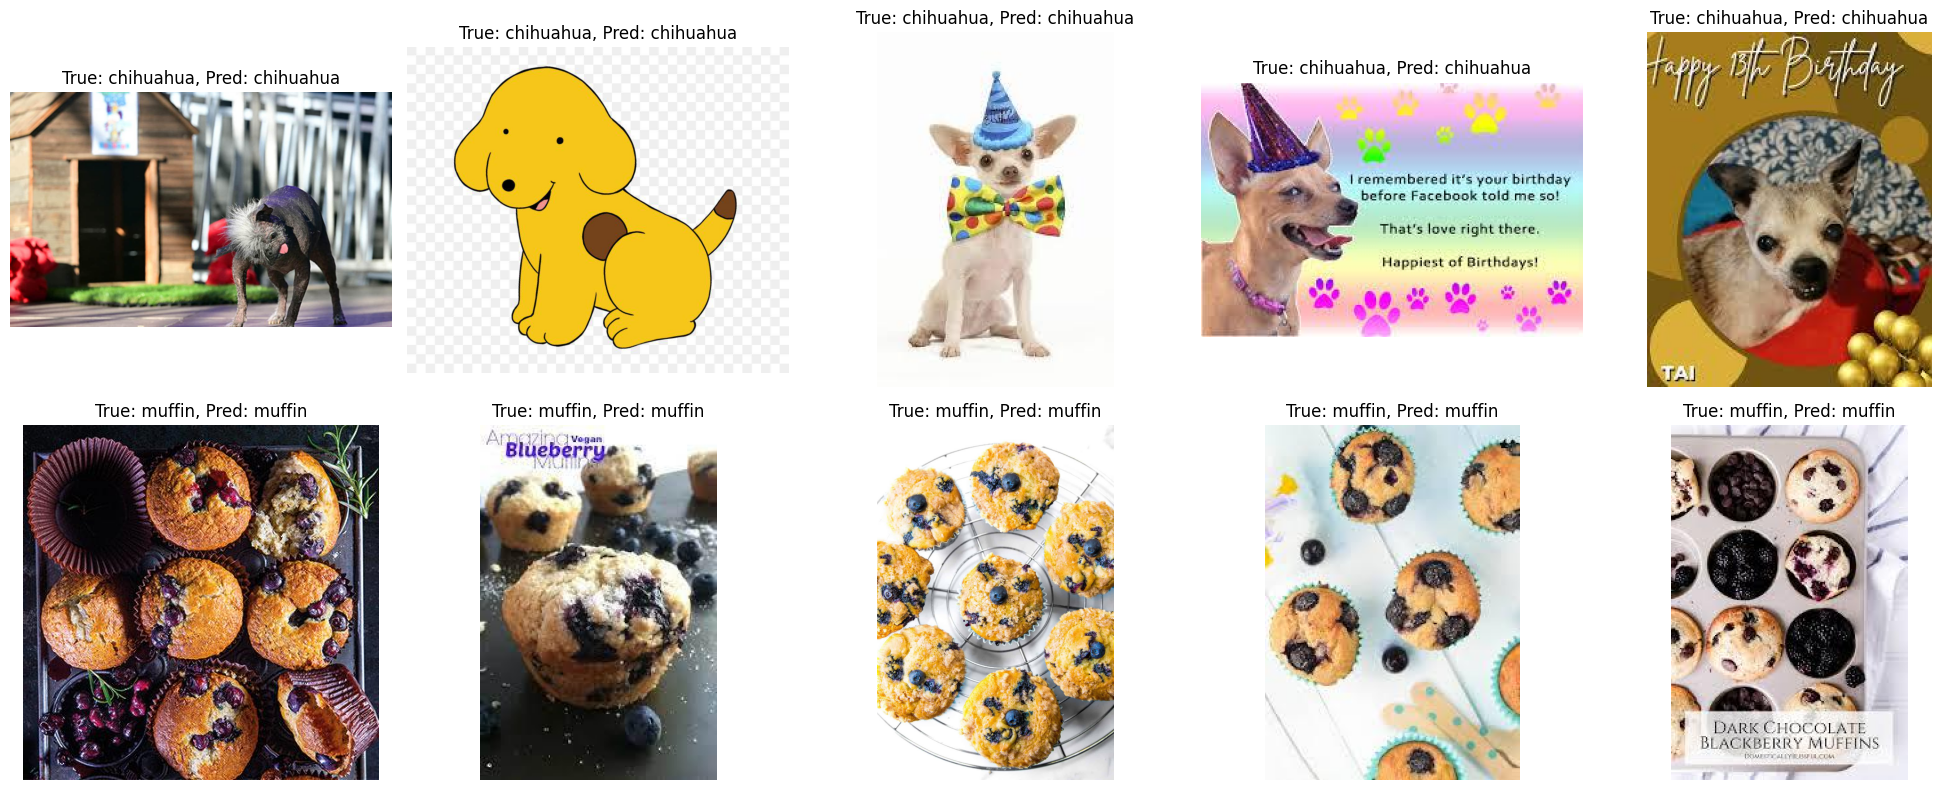

In [91]:
class_folders = {
    'chihuahua': '../실습 파일/6/test/chihuahua',
    'muffin': '../실습 파일/6/test/muffin'
}

plt.figure(figsize=(20, 8))
# subplot 인덱스를 위한 카운터
counter = 1

# 각 클래스별로 5장의 이미지 추론 및 시각화
for class_name, folder_path in class_folders.items():
    # 해당 클래스의 이미지 경로 가져오기
    image_paths = glob.glob(os.path.join(folder_path, '*'))
    selected_paths = image_paths[:5]  # 첫 5장 선택

    for image_path in selected_paths:
        image = load_and_transform_image(image_path, pytorch_transform)
        image = image.to(device)

        net.eval()  # 모델을 평가 모드로 설정
        # 모델을 사용한 추론
        with torch.no_grad():
            outputs = net(image)
            _, predicted = torch.max(outputs, 1)
        prediction = 'chihuahua' if predicted.item() == 0 else 'muffin'

        # 결과 시각화
        plt.subplot(2, 5, counter)
        plt.imshow(Image.open(image_path))
        plt.title(f'True: {class_name}, Pred: {prediction}')
        plt.axis('off')

        counter += 1  # subplot 인덱스 업데이트

plt.tight_layout()
plt.show()

In [97]:
net = resnet50(num_classes=1000)


# 사전 학습된 모델의 features 부분에서 가중치 추출
pretrained_keys = set(pretrained_resnet50.state_dict().keys())
# 사전 학습된 모델에서 커스텀 모델로 가중치 복사 시도
result = net.load_state_dict(pretrained_resnet50.state_dict(), strict=False)

for param in net.parameters():
    param.requires_grad = False
# 새로 정의한 모델 인스턴스 생성

net.fc = nn.Linear(2048, 2)

for param in net.fc.parameters():
    param.requires_grad = True

net = net.to(device)



In [98]:
train_losses_AdamW, val_losses_AdamW, val_accuracies_AdamW = train_model('AdamW', net, train_loader, val_loader, criterion, num_epochs=10)
train_losses_RAdam, val_losses_RAdam, val_accuracies_RAdam = train_model('RAdam', net, train_loader, val_loader, criterion, num_epochs=10)

Epoch 1/10, Train Loss: 0.3973, Val Loss: 0.1607, Val Accuracy: 98.04%
Epoch 2/10, Train Loss: 0.2328, Val Loss: 0.1055, Val Accuracy: 97.28%
Epoch 3/10, Train Loss: 0.1824, Val Loss: 0.0664, Val Accuracy: 98.64%
Epoch 4/10, Train Loss: 0.1635, Val Loss: 0.0602, Val Accuracy: 98.38%
Epoch 5/10, Train Loss: 0.1450, Val Loss: 0.0583, Val Accuracy: 98.30%
Epoch 6/10, Train Loss: 0.1353, Val Loss: 0.0522, Val Accuracy: 98.13%
Epoch 7/10, Train Loss: 0.1307, Val Loss: 0.0466, Val Accuracy: 98.64%
Epoch 8/10, Train Loss: 0.1278, Val Loss: 0.0428, Val Accuracy: 98.47%
Epoch 9/10, Train Loss: 0.1248, Val Loss: 0.0386, Val Accuracy: 98.98%
Epoch 10/10, Train Loss: 0.1255, Val Loss: 0.0399, Val Accuracy: 98.55%
Epoch 1/10, Train Loss: 0.1139, Val Loss: 0.0443, Val Accuracy: 98.38%
Epoch 2/10, Train Loss: 0.1149, Val Loss: 0.0438, Val Accuracy: 98.55%
Epoch 3/10, Train Loss: 0.1078, Val Loss: 0.0348, Val Accuracy: 98.81%
Epoch 4/10, Train Loss: 0.1118, Val Loss: 0.0355, Val Accuracy: 98.72%
Epoch

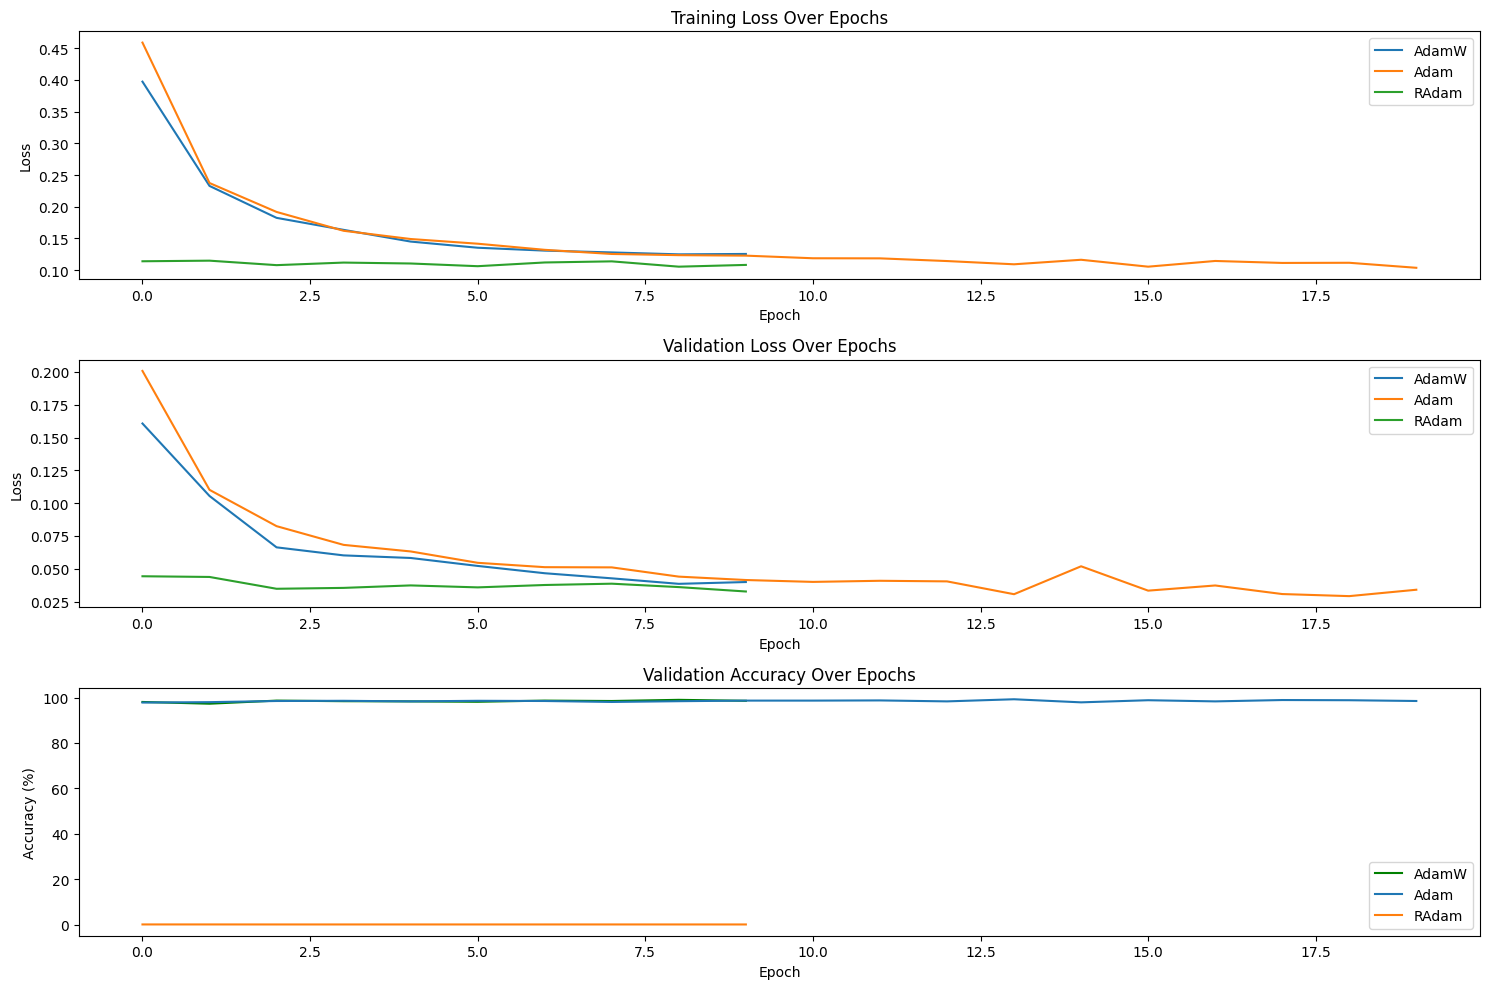

In [99]:
# 학습 손실과 검증 정확도 그래프 그리기
plt.figure(figsize=(15, 10))

# 학습 손실 그래프
plt.subplot(3, 1, 1)  # 3행 1열의 첫 번째 위치
plt.plot(train_losses_AdamW, label='AdamW')
plt.plot(train_losses_Adam[0], label='Adam')
plt.plot(train_losses_RAdam, label='RAdam')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()

# 검증 손실 그래프
plt.subplot(3, 1, 2)  # 3행 1열의 두 번째 위치
plt.plot(val_losses_AdamW, label='AdamW')
plt.plot(train_losses_Adam[1], label='Adam')
plt.plot(val_losses_RAdam, label='RAdam')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Validation Loss Over Epochs')
plt.legend()

# 검증 정확도 그래프
plt.subplot(3, 1, 3)  # 3행 1열의 세 번째 위치
plt.plot(val_accuracies_AdamW, label='AdamW', color='green')
plt.plot(train_losses_Adam[2], label='Adam')
plt.plot(val_losses_RAdam, label='RAdam')

plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Validation Accuracy Over Epochs')
plt.legend()

plt.tight_layout()
plt.show()